In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import GPy
import my_lib
import acquisitions as ac
from sklearn import preprocessing
import os
from contextlib import redirect_stdout
%matplotlib inline
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
def f(x):
    return 1.0*np.sin((x+0.4)*5)
np.random.seed(44)
_X = np.random.rand(3)
X = _X.copy()
Y = f(X)
X_array = np.linspace(0.01, 1.01, 100)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


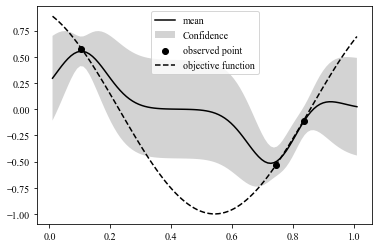

In [3]:
fig = plt.figure()
m = GPy.models.GPRegression(X[:,None],Y[:,None])
m.Gaussian_noise.variance = abs(0.01)
m.Gaussian_noise.variance.fix()
with redirect_stdout(open(os.devnull, 'w')):
    m.optimize_restarts(num_restarts=100, messages=False, max_iters=10)
mu, std = np.array(m.predict(X_array[:, None]))
plt.plot(X_array, mu, c='black', label='mean')
plt.fill_between(X_array,(mu+(std**0.5)).reshape(-1),(mu-(std**0.5)).reshape(-1),facecolor='lightgray', label='Confidence')
plt.scatter(X, Y, c ='black', label ='observed point')
plt.plot(X_array, f(X_array), c='black', linestyle = "dashed", label='objective function')
plt.legend()
fig.savefig('1.eps')

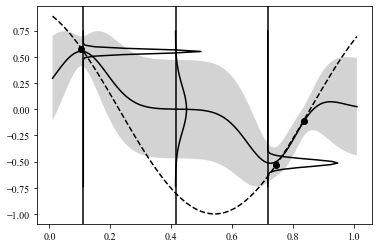

In [4]:
fig = plt.figure()
plt.plot(X_array, mu, c='black', label='mean')
plt.fill_between(X_array,(mu+(std**0.5)).reshape(-1),(mu-(std**0.5)).reshape(-1),facecolor='lightgray', label='Confidence')
plt.scatter(X, Y, c ='black', label ='observed point')
plt.plot(X_array, f(X_array), c='black', linestyle = "dashed", label='True function')
sample = np.linspace(10, 70, 3).astype(np.int)
tmp = np.linspace(np.min(mu-(std**0.5)), np.max(mu+(std**0.5)), 100)
for s in sample:
    dist = sc.stats.norm.pdf(tmp, mu[s],std[s])*0.02
    plt.plot(dist+X_array[s], tmp, c = 'black')
    plt.axvline(x=X_array[s], c = 'black')
fig.savefig('2.eps')

In [5]:
PI  = ac.AcquisitionEI()
EI  = ac.AcquisitionPI()
UCB = ac.AcquisitionGPUCB()

In [6]:
mms = preprocessing.MinMaxScaler()
pi  = mms.fit_transform(PI.acq(mu, std))
pi_idx = np.argmax(pi)
ei  = mms.fit_transform(EI.acq(mu, std))
ei_idx = np.argmax(ei)
ucb = mms.fit_transform(UCB.acq(mu, std))
ucb_idx = np.argmax(ucb)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


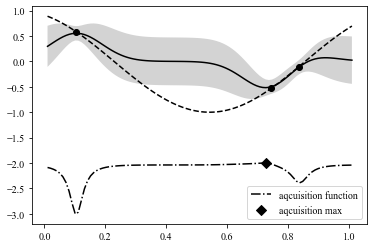

In [7]:
fig = plt.figure()
plt.plot(X_array, mu, c='black')
plt.fill_between(X_array,(mu+(std**0.5)).reshape(-1),(mu-(std**0.5)).reshape(-1),facecolor='lightgray')
plt.scatter(X, Y, c ='black')
plt.plot(X_array, f(X_array), c='black', linestyle = "dashed")

#plt.plot(X_array, pi-3, c='g', label='aqcuisition function', linestyle = "dashdot")
plt.plot(X_array, ei-3, c='black', label='aqcuisition function', linestyle = "dashdot")
#plt.plot(X_array, ucb-3,c='purple', label='GP-UCB')

#plt.scatter(X_array[pi_idx], pi[pi_idx]-3, c='purple', marker='D', label='aqcuisition max', s=50)
plt.scatter(X_array[ei_idx], ei[ei_idx]-3, c='black', marker='D', label='aqcuisition max', s=50)
#plt.scatter(X_array[ucb_idx], ucb[ucb_idx]-3, c='purple')

plt.legend()
fig.savefig('3.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2/4.......0.01
0.1
1
3/4.......0.01
0.1
1
4/4.......

<Figure size 432x288 with 0 Axes>

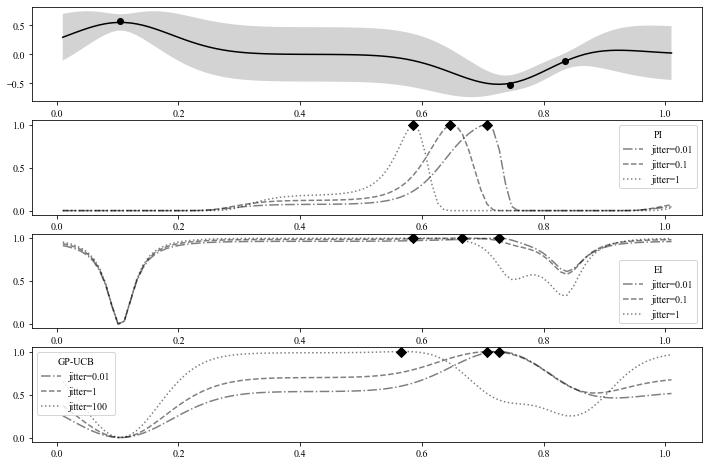

In [8]:
fig = plt.figure()
nrows=4
ncols=1
#pi
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(12,8))
mu, std = np.array(m.predict(X_array[:, None]))
ax[0].plot(X_array, mu, c='black', label='mean')
ax[0].fill_between(X_array,(mu+(std**0.5)).reshape(-1),(mu-(std**0.5)).reshape(-1),facecolor='lightgray', label='Confidence')
ax[0].scatter(X, Y, c ='black')
for i in range(1, nrows*ncols):
    print(f'\r{i+1}/{nrows*ncols}.......', end='')
    _r= i//ncols
    _c= i%ncols
    acqs = [PI, EI, UCB]
    acqs_st = ['PI', 'EI', 'GP-UCB']
    params = [[0.01, 0.1, 1], [0.01, 0.1, 1], [0.01, 1, 100]]
    colors = ['g', 'b', 'r']
    linestyle = ["dashdot", "dashed", "dotted"]
    for j in range(3):
        if i == 3:
            acqs[i-1].beta = params[i-1][j]
        else:
            acqs[i-1].jitter = params[i-1][j]
            print(acqs[i-1].jitter)
        acq  = mms.fit_transform(acqs[i-1].acq(mu, std))
        idx = np.argmax(acq)
        
        ax[_r].plot(X_array, acq, c='black', alpha=0.5, label=f'jitter={params[i-1][j]}', linestyle = linestyle[j])
        ax[_r].scatter(X_array[idx], acq[idx], c='black', s = 50, marker='D')
    ax[_r].legend(title=acqs_st[i-1])
fig.savefig('4.eps')

In [9]:
nrows=4
ncols=3

4/12.......

 /mnt/nfs/kawanan/anaconda3/envs/intern/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


12/12.......

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


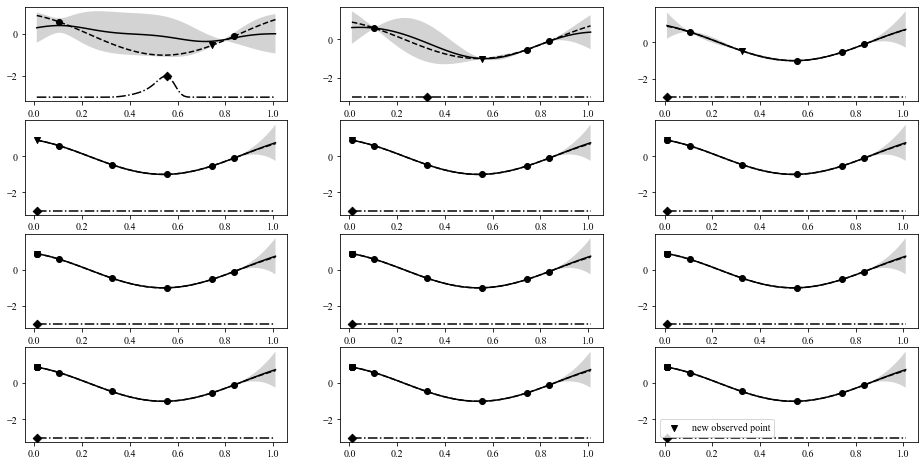

In [10]:
#pi
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16,8))
X = _X.copy()
Y = f(X)
for i in range(nrows*ncols):
    print(f'\r{i+1}/{nrows*ncols}.......', end='')
    _r= i//ncols
    _c= i%ncols
    m = GPy.models.GPRegression(X[:,None],Y[:,None])
    with redirect_stdout(open(os.devnull, 'w')):
        m.optimize_restarts(num_restarts=100, messages=False, max_iters=10)
    mu, std = np.array(m.predict(X_array[:, None]))
    acq  = mms.fit_transform(PI.acq(mu, std))
    idx = np.argmax(acq)
    std = mms.fit_transform(std)
    ax[_r, _c].plot(X_array, mu, c='black')
    ax[_r, _c].fill_between(X_array,(mu+(std**0.5)).reshape(-1),(mu-(std**0.5)).reshape(-1),facecolor='lightgray')
    ax[_r, _c].scatter(X[:-1], Y[:-1], c ='black')
    ax[_r, _c].scatter(X[-1:], Y[-1:], c ='black', label ='new observed point', marker='v')
    ax[_r, _c].plot(X_array, f(X_array), c='black', linestyle = "dashed")
    
    ax[_r, _c].plot(X_array, acq-3, c='black', linestyle = "dashdot")
    ax[_r, _c].scatter(X_array[idx], acq[idx]-3, c='black', marker='D')
    
    X = np.append(X, X_array[idx])
    Y = np.append(Y, f(X_array[idx]))
plt.legend()
fig.savefig('5.eps')

12/12.......

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


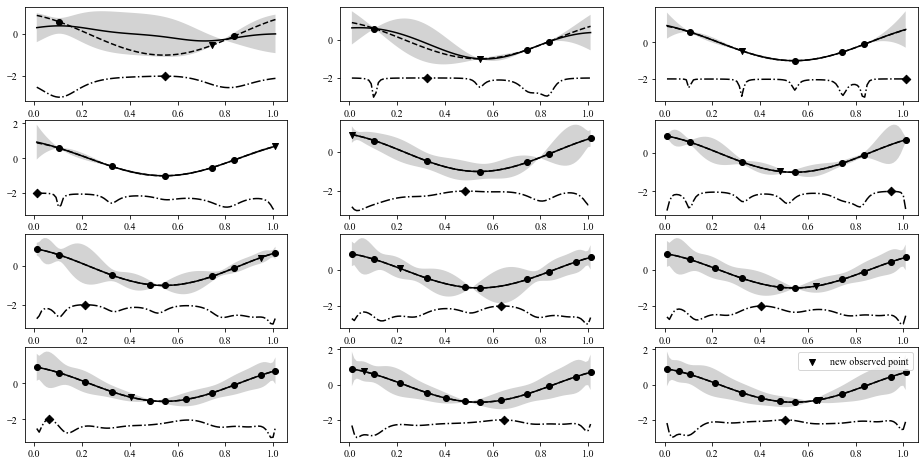

In [11]:
#ei
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16,8))
X = _X.copy()
Y = f(X)
for i in range(nrows*ncols):
    print(f'\r{i+1}/{nrows*ncols}.......', end='')
    _r= i//ncols
    _c= i%ncols
    m = GPy.models.GPRegression(X[:,None],Y[:,None])
    with redirect_stdout(open(os.devnull, 'w')):
        m.optimize_restarts(num_restarts=100, messages=False, max_iters=10)
    mu, std = np.array(m.predict(X_array[:, None]))
    acq  = mms.fit_transform(EI.acq(mu, std))
    idx = np.argmax(acq)
    std = mms.fit_transform(std)
    
    ax[_r, _c].plot(X_array, mu, c='black')
    ax[_r, _c].fill_between(X_array,(mu+(std**0.5)).reshape(-1),(mu-(std**0.5)).reshape(-1),facecolor='lightgray')
    ax[_r, _c].scatter(X[:-1], Y[:-1], c ='black')
    ax[_r, _c].scatter(X[-1:], Y[-1:], c ='black', label ='new observed point', marker='v')
    ax[_r, _c].plot(X_array, f(X_array), c='black', linestyle = "dashed")
    
    ax[_r, _c].plot(X_array, acq-3, c='black', linestyle = "dashdot")
    ax[_r, _c].scatter(X_array[idx], acq[idx]-3, c='black', marker='D')
    
    X = np.append(X, X_array[idx])
    Y = np.append(Y, f(X_array[idx]))
plt.legend()
fig.savefig('6.eps')

6/12.......

 /mnt/nfs/kawanan/anaconda3/envs/intern/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


9/12.......

 /mnt/nfs/kawanan/anaconda3/envs/intern/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


10/12.......

 /mnt/nfs/kawanan/anaconda3/envs/intern/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


12/12.......

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


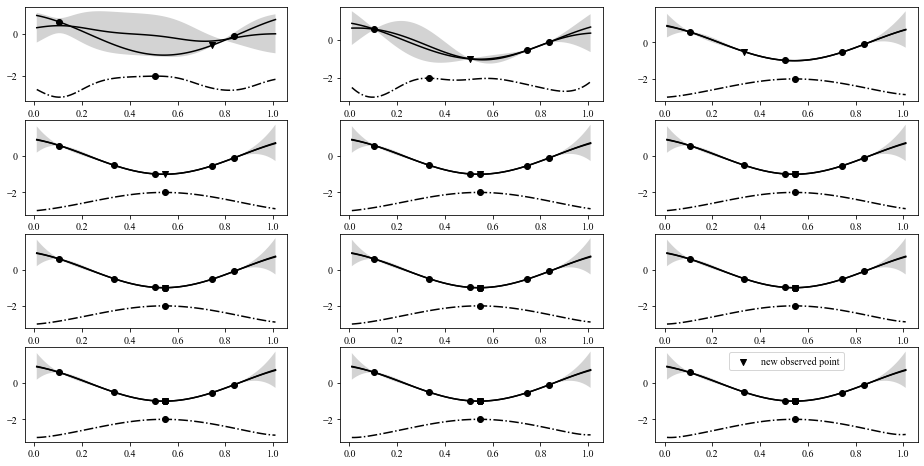

In [12]:
#GP-UCB
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(16,8))
X = _X.copy()
Y = f(X)
UCB.beta=100.
for i in range(nrows*ncols):
    print(f'\r{i+1}/{nrows*ncols}.......', end='')
    _r= i//ncols
    _c= i%ncols
    m = GPy.models.GPRegression(X[:,None],Y[:,None])
    with redirect_stdout(open(os.devnull, 'w')):
        m.optimize_restarts(num_restarts=100, messages=False, max_iters=10)
    mu, std = np.array(m.predict(X_array[:, None]))
    acq  = mms.fit_transform(UCB.acq(mu, std))
    UCB.beta *= 2
    idx = np.argmax(acq)
    std = mms.fit_transform(std)
    
    
    ax[_r, _c].plot(X_array, mu, c='black')
    ax[_r, _c].fill_between(X_array,(mu+(std**0.5)).reshape(-1),(mu-(std**0.5)).reshape(-1),facecolor='lightgray')
    ax[_r, _c].scatter(X[:-1], Y[:-1], c ='black')
    ax[_r, _c].scatter(X[-1:], Y[-1:], c ='black', label ='new observed point', marker='v')
    ax[_r, _c].plot(X_array, f(X_array), c='black')
    
    ax[_r, _c].plot(X_array, acq-3, c='black', linestyle = "dashdot")
    ax[_r, _c].scatter(X_array[idx], acq[idx]-3, c='black')
    
    X = np.append(X, X_array[idx])
    Y = np.append(Y, f(X_array[idx]))
plt.legend()
fig.savefig('7.eps')